In [1]:
from unityagents import UnityEnvironment
import numpy as np

# Continuous Control

---

In this notebook, we show how to use the Unity ML-Agents environment for solving Continuous control problem.

### 1. Start the Environment


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`


In [2]:
# env = UnityEnvironment(file_name='local_test/Reacher_Windows_x86_64/Reacher.exe', seed = 0)  ##single agent env ## mutlip-agent env, seed = 0
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe', seed = 0)  ##multi agent env ## mutlip-agent env, seed = 0



INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  


In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))


Total score (averaged over agents) this episode: 0.15249999659135938


### 4. Train the smart agent

Deep Deterministic Policy Gradient(DDPG) RL algorithm is introduced by deep mind, [https://arxiv.org/abs/1509.02971]paper ref DDPG adapts the Deep Q-Learning (DQN) to the continuous action domain with Actor-Critic methods. Actor or critic each has   two neteworks like DQN: target and regular.  
The actor directly maps states to actions, and critic utilizes the best action from actor to calculate the next-state Q value. Then we minimize the mean-squared loss between the updated Q value and the original Q value like DQN.
The actor's objective is to maximize the expected return. To calculate the policy loss, we take the derivative of the objective function with respect to the policy parameter. 
The target network weight is updated with so-called soft update by slowly mixing the target and regular networks to target network weight. 
Exploration is done via adding noise to the action itself. In the DDPG paper, the authors use Ornstein-Uhlenbeck Process to add noise to the action output.

Episode 110	Averag Score: 27.93
En)ironment solved in 17 episodes!	Average Score: 30.20


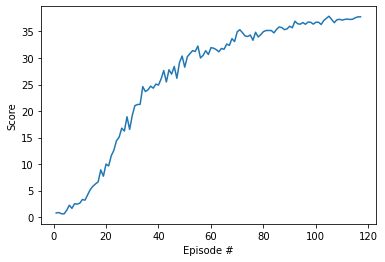

In [6]:
from ddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import torch

agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)
def ddpg(n_episodes=1000, max_t=1000, print_every=10):
    scores_deque = deque(maxlen=100)
    scores_mean = []
    for i_episode in range(1, n_episodes+1):
        # state = env.reset()
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment  
        states = env_info.vector_observations         # get the current state (for each agent)
        scores = np.zeros(num_agents)
        agent.reset()

        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]     # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
        scores_deque.append(np.mean(scores))
        scores_mean.append(np.mean(scores))

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverag Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if np.mean(scores_deque) > 30 and len(scores_deque) >= 100:
            print('\nEn)ironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    return scores_mean

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [ ]:
env.close()

When finished, we close the environment.